# 1.0 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

sns.set_style("whitegrid")

%matplotlib inline

# 2.0 EDA

## 2.1 Reading Data

In [3]:
url = "https://raw.githubusercontent.com/tofighi/MachineLearning/master/datasets/heart.csv"

df = pd.read_csv(url, error_bad_lines = False)

df.drop( labels = 'row.names', axis = 1, inplace = True )

df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


## 2.2 Percentage of Class 0 & 1

In [4]:
class_0 = len( df[ df['chd'] == 0 ] ) / len(df)
class_1 = len( df[ df['chd'] == 1 ] ) / len(df)

print(f"The percentage for class 0: {class_0}")
print(f"The percentage for class 1: {class_1}")

The percentage for class 0: 0.6536796536796536
The percentage for class 1: 0.3463203463203463


## 2.3 Missing Data

In [5]:
# no missing values

print ( df.isnull().sum() )

sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64


## 2.4 Data Types

In [7]:
# only one categorical column which is famhist

df.dtypes

sbp            int64
tobacco      float64
ldl          float64
adiposity    float64
famhist       object
typea          int64
obesity      float64
alcohol      float64
age            int64
chd            int64
dtype: object

## 2.5 Correlation Before One Hot Encoding

<AxesSubplot:>

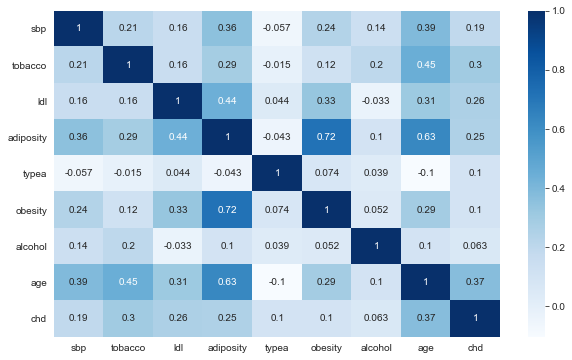

In [8]:
# famhist column is removed because it is categorical
# top 3 correlations: 
# 1- adiposity vs obesity (value = 0.72)
# 2- adiposity vs age (value = 0.63)
# 3- tobacco vs age (value = 0.45)

plt.figure (figsize = (10,6))
sns.heatmap( df.corr(), cmap = "Blues", annot = True )

## 2.6 Helper Functions

### 2.6.1 Mean 

In [9]:
def data_mean( df ):
    
    results = []

    for c in df.columns:

        results.append( df[c].values.mean() )

    return results

### 2.6.2 Standard Deviation

In [10]:
def data_std ( df ):
    
    results = []

    for c in df.columns:

        results.append( df[c].values.std() )

    return results

### 2.6.3 Data Standardization

In [11]:
def standardize_data ( df, mean, std ):
    
    df_temp = df.copy()
    
    for i, c in enumerate ( df.columns ):
        
        df_temp [c] = ( df_temp - mean[i] ) / std[i]
    
    return df_temp

### 2.6.4 One Hot Encoder

In [12]:
def one_hot_encoder (df):

    df_res = pd.DataFrame () 

    for c in df.columns:

        temp_col = pd.get_dummies(df[c], prefix=c)

        df_res = pd.concat( [df_res, temp_col] , axis = 1 ) 

    return df_res

### 2.6.5 Initialize Weights

In [13]:
def initialize_weights (df):
    
    num = len(df.columns) - 2
    
    weights = np.random.rand(1,num)
    
    return weights

### 2.6.6 Cost Plotter

In [14]:
def cost_plotter (x , y):
    
    plt.figure(figsize = (10,6))

    plt.plot(x, y, c = "red")

    plt.title("Error along Iterations", fontsize = 18)
    plt.xlabel ( "Iterations", fontsize= 15 )
    plt.ylabel( "Error", fontsize = 15 )
    plt.show()

### 2.6.7 Preprocess Data

In [15]:
def preprocess_data(df):
    
    df_temp = df.copy()
    
    numerical_cols = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity',
           'alcohol', 'age']

    categorical_cols = ['famhist']

    df_numerical = df_temp[ numerical_cols ]
    
    mean = data_mean( df_numerical )
    std = data_std ( df_numerical )
    
    df_numerical = standardize_data (df_numerical, mean, std)

    df_categorical = df_temp[ categorical_cols ]
    
    df_categorical = one_hot_encoder(df_categorical)

    df_res = pd.concat ( [df_numerical, df_categorical], axis = 1 )
    
    df_res['chd'] = df_temp['chd']
    
    df_res['probabilities'] = -1
    
    df_res.insert(0,'x0',[1]*len(df_res))
    
    df_res = df_res[[ 'x0', 'sbp', 'tobacco', 'ldl', 'adiposity', 'famhist_Absent', 'famhist_Present', 'typea', 'obesity',
       'alcohol', 'age', 'chd', 'probabilities' ]]
    
    return df_res

## 2.6.8 Correlation after Preprocessing

<AxesSubplot:>

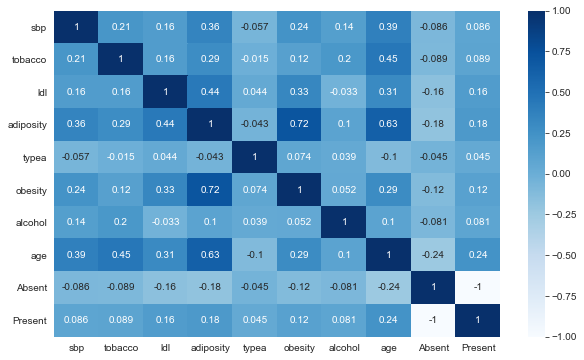

In [16]:
# famhist column is removed because it is categorical
# top 3 correlations: 
# 1- Absent vs Present (value = -1 )
# 2- adiposity vs obesity (value = 0.72)
# 3- adiposity vs age (value = 0.63)

x = df [ ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity',
       'alcohol', 'age'] ]

x = np.append(x, pd.get_dummies(df['famhist']).values, axis = 1)

df_corr = pd.DataFrame (x, columns=['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity',
       'alcohol', 'age', 'Absent', 'Present'])

plt.figure (figsize = (10,6))
sns.heatmap( df_corr.corr(), cmap = "Blues", annot = True )

# 3.0 Logistic Regression

## 3.1 Helper Functions

### 3.1.1 Sigmoid

In [17]:
def sigmoid (df, weights):
    
    df_temp = df.copy()
            
    p = 1 / ( 1 + np.exp ( - np.dot(df_temp.iloc[:,:-2], weights.reshape(11,1) ) ) )
        
    df_temp['probabilities'] = p
        
    return df_temp

### 3.1.2 Cost

In [18]:
def cross_entropy ( df ):
    
#     print(df.head())
    
    y = df['chd']
    predicted = df['probabilities']
    
    return -( np.sum (y * np.log(predicted) + (1-y) * np.log(1-predicted)) ) / len(df)

### 3.1.3 Gradient

In [19]:
def gradient ( df ):
    
    df_temp = df.copy()
        
    res = []
    
    for c in df.columns[:-2]:
        
        temp_val = np.sum ( ( df['chd'] - df['probabilities'] ) * df[c] )
        
        res.append( temp_val/len(df) ) 
    
    return res

### 3.1.4 Batch Gradient Descent

In [20]:
def batch_gradient_descent ( df, weights, learning_rate, num_epochs ):
    
    df_temp = df.copy()
    
    iterations = []
    costs = []

    df_res = sigmoid(df_temp, weights)
    cost = cross_entropy (df_res)
    iterations.append ( 0 )
    costs.append ( cost )
    
    for i in range ( num_epochs ):

        gradients = gradient ( df_res )

        for j in range ( len ( gradients ) ):

            weights[0][j] = weights[0][j] + ( learning_rate * gradients[j] )

        df_res = sigmoid(df_res, weights)

        cost = cross_entropy (df_res)

        iterations.append ( i+1 )
        costs.append ( cost )
        
    return iterations, costs, df_res

### 3.1.5 Mini Batch Gradient Descent

In [26]:
def mini_batch_gradient_descent ( df, weights, learning_rate, num_epochs,batch_size  ):
    
    df_temp = df.copy()
    
    iterations = []
    costs = []

    df_res = sigmoid(df_temp, weights)
    cost = cross_entropy (df_res)
    iterations.append ( 0 )
    costs.append ( cost )
    
    for i in range ( num_epochs ):

        for m in range(0,len(df_res),batch_size):

            gradients = gradient ( df_res.iloc[m:m+batch_size] )

            for j in range ( len ( gradients ) ):

                weights[0][j] = weights[0][j] + ( learning_rate * gradients[j] )

            df_res = sigmoid(df_res, weights)

        cost = cross_entropy (df_res)

        iterations.append ( i+1 )
        costs.append ( cost )

    return iterations, costs, df_res

### 3.1.6 Acuracy

In [22]:
from sklearn.metrics import accuracy_score

def accuracy ( df, threshold ):
    
    df_temp = df.copy()
    
    df_temp['predicted'] = df_temp['probabilities'].apply( lambda j: 1 if j >= threshold else 0)
    
    return accuracy_score(df_temp['chd'], df_temp['predicted'])

## 3.2 Logistic Regression

### 3.2.1 Custom Model 

In [23]:
def logistic_regression ( df, learning_rate, num_epochs, batch_size = None, seed = 481999, threshold = 0.5 ):
    
    df_temp = df.copy()
    
    np.random.seed(seed)
    
    df_res = preprocess_data(df_temp)
          
    weights = initialize_weights(df_res)
        
    if batch_size == None:
        
        iterations, costs, df_temp_2 = batch_gradient_descent (df_res, weights, learning_rate, num_epochs)
        model_accuracy = accuracy(df_temp_2, threshold)
    else:
        
        iterations, costs, df_temp_2 = mini_batch_gradient_descent (df_res, weights, learning_rate, num_epochs, batch_size)
        model_accuracy = accuracy(df_temp_2, threshold)
        
    print(f"The accuracy is: {model_accuracy}")
    cost_plotter(iterations, costs)

**Case #1:** Batch Gradient Descent + learning rate = 0.001 + number of epochs = 500

The accuracy is: 0.6645021645021645


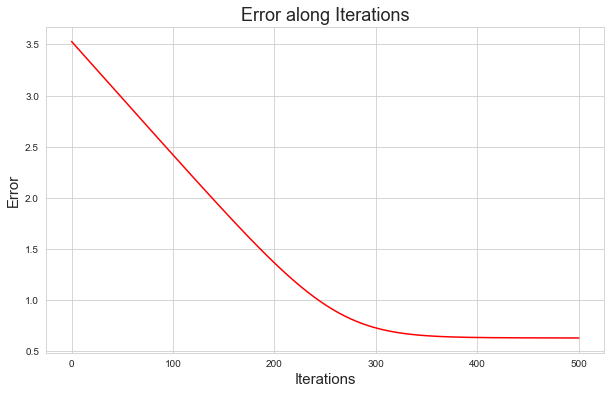

In [110]:
learning_rate = 0.001
num_epochs = 500

logistic_regression ( df, learning_rate, num_epochs, batch_size= None, seed = 481999, threshold= 0.5 )

**Case #2:** Batch Gradient Descent + learning rate = 0.0001 + number of epochs = 500

The accuracy is: 0.6536796536796536


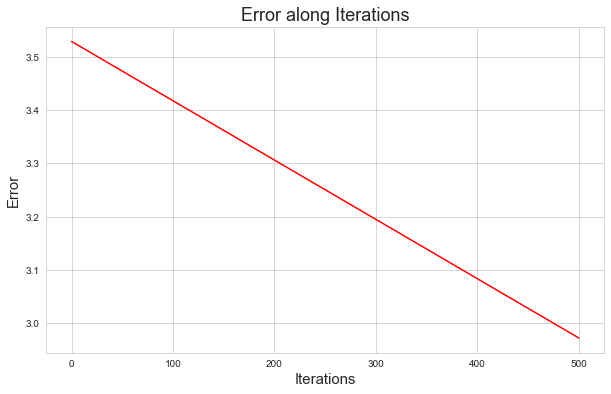

In [112]:
learning_rate = 0.0001
num_epochs = 500

logistic_regression ( df, learning_rate, num_epochs, batch_size= None, seed = 481999, threshold= 0.5 )

**Case #3:** Batch Gradient Descent + learning rate = 0.001 + number of epochs = 1000

The accuracy is: 0.6666666666666666


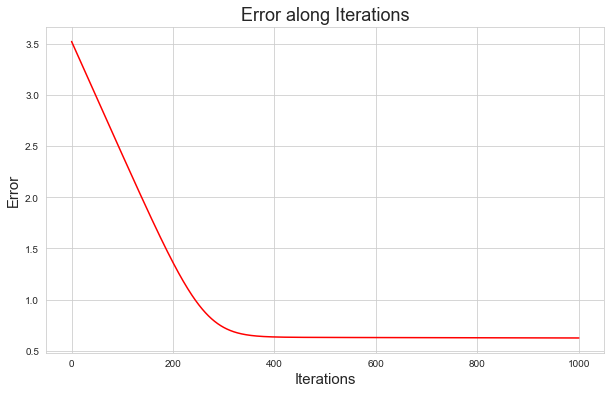

In [113]:
learning_rate = 0.001
num_epochs = 1000

logistic_regression ( df, learning_rate, num_epochs, batch_size= None, seed = 481999, threshold= 0.5 )

**Case #4:** Batch Gradient Descent + learning rate = 0.0001 + number of epochs = 1000

The accuracy is: 0.6536796536796536


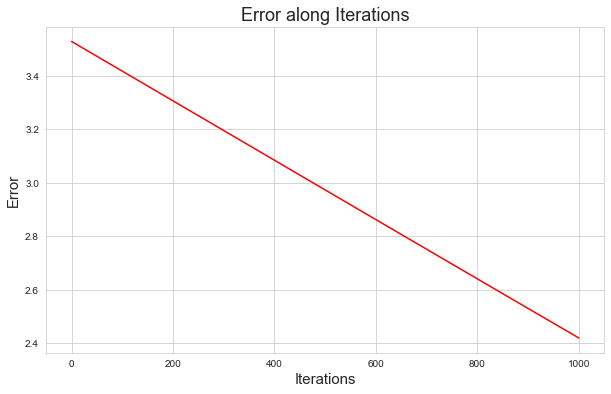

In [114]:
learning_rate = 0.0001
num_epochs = 1000

logistic_regression ( df, learning_rate, num_epochs, batch_size= None, seed = 481999, threshold= 0.5 )

**Case #5:** Batch Gradient Descent + learning rate = 0.001 + number of epochs = 10000

The accuracy is: 0.6883116883116883


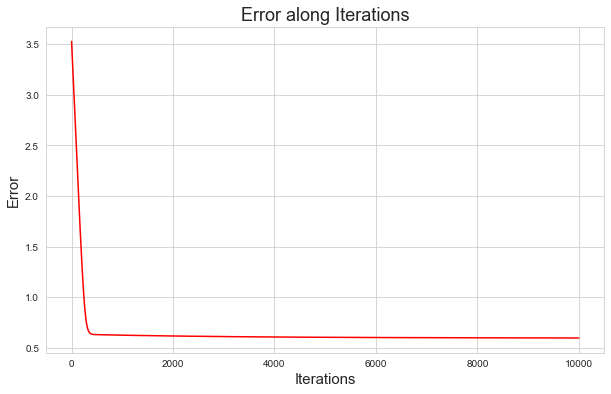

In [24]:
learning_rate = 0.001
num_epochs = 10000

logistic_regression ( df, learning_rate, num_epochs, batch_size= None, seed = 481999, threshold= 0.5 )

**Case #6:** Batch Gradient Descent + learning rate = 0.0001 + number of epochs = 10000

The accuracy is: 0.6666666666666666


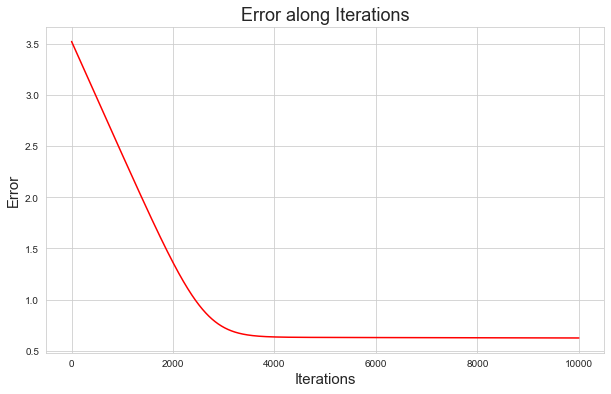

In [116]:
learning_rate = 0.0001
num_epochs = 10000

logistic_regression ( df, learning_rate, num_epochs, batch_size= None, seed = 481999, threshold= 0.5 )

**Case #7:** Mini Batch Gradient Descent + learning rate = 0.001 + number of epochs = 500

The accuracy is: 0.6926406926406926


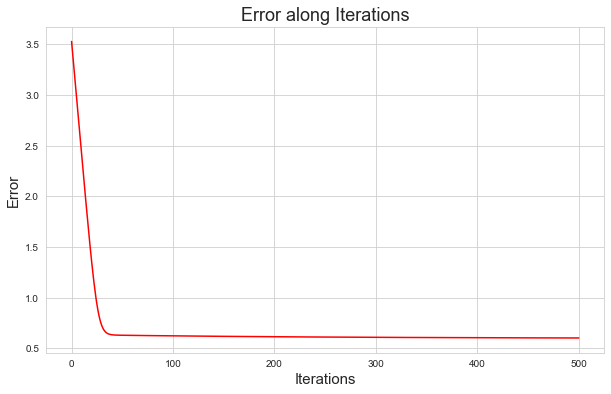

In [119]:
learning_rate = 0.001
num_epochs = 500

logistic_regression ( df, learning_rate, num_epochs, batch_size= 50, seed = 481999, threshold= 0.5 )

**Case #8:** Mini Batch Gradient Descent + learning rate = 0.0001 + number of epochs = 500

The accuracy is: 0.6645021645021645


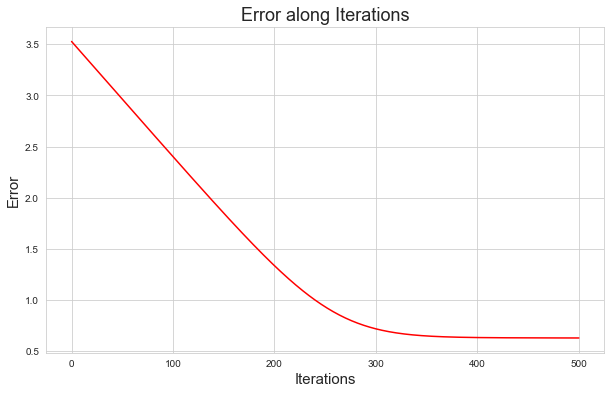

In [120]:
learning_rate = 0.0001
num_epochs = 500

logistic_regression ( df, learning_rate, num_epochs, batch_size= 50, seed = 481999, threshold= 0.5 )

**Case #9:** Mini Batch Gradient Descent + learning rate = 0.001 + number of epochs = 1000

The accuracy is: 0.6904761904761905


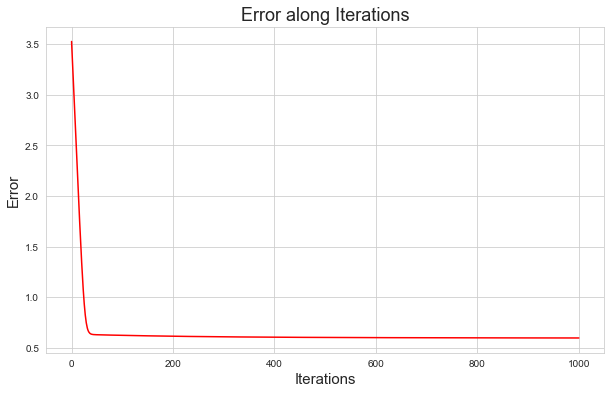

In [122]:
learning_rate = 0.001
num_epochs = 1000

logistic_regression ( df, learning_rate, num_epochs, batch_size= 50, seed = 481999, threshold= 0.5 )

**Case #10:** Mini Batch Gradient Descent + learning rate = 0.0001 + number of epochs = 1000

The accuracy is: 0.6666666666666666


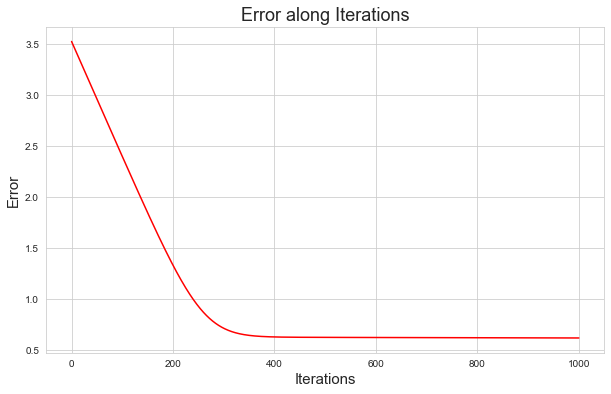

In [123]:
learning_rate = 0.0001
num_epochs = 1000

logistic_regression ( df, learning_rate, num_epochs, batch_size= 50, seed = 481999, threshold= 0.5 )

**Case #11:** Mini Batch Gradient Descent + learning rate = 0.001 + number of epochs = 10000

The accuracy is: 0.6818181818181818


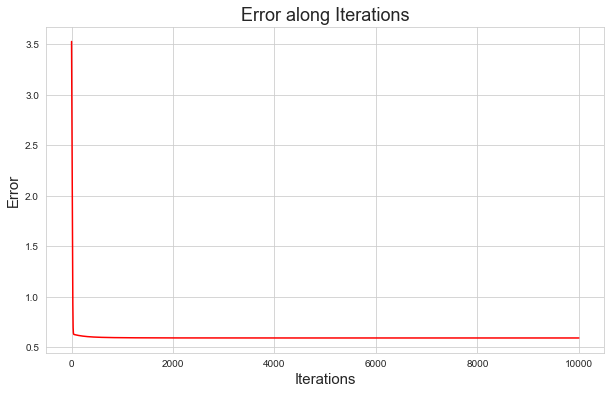

In [124]:
learning_rate = 0.001
num_epochs = 10000

logistic_regression ( df, learning_rate, num_epochs, batch_size= 50, seed = 481999, threshold= 0.5 )

**Case #12:** Mini Batch Gradient Descent + learning rate = 0.0001 + number of epochs = 10000

The accuracy is: 0.6904761904761905


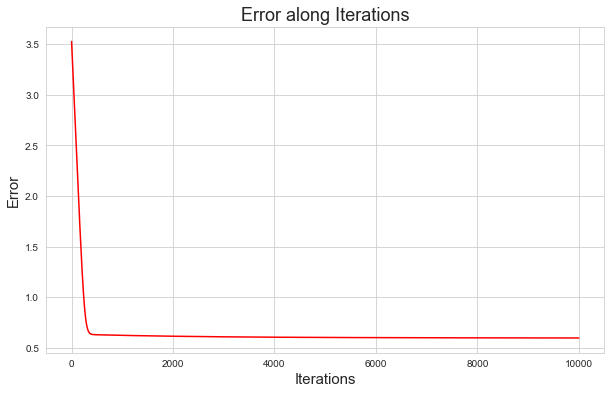

In [27]:
learning_rate = 0.0001
num_epochs = 10000

logistic_regression ( df, learning_rate, num_epochs, batch_size= 50, seed = 481999, threshold= 0.5 )

###  3.2.2 Built-in Functions (Scikit-Learn)

In [161]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

scalar = StandardScaler()

df_res = preprocess_data (df).iloc[:,1:-1]

x = df [ ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity',
       'alcohol', 'age'] ]

x = scalar.fit_transform(x)

x = np.append(x, pd.get_dummies(df['famhist']).values, axis = 1)

y = df['chd']
 
log = LogisticRegression()

log.fit(x, y)

y_predicted = log.predict (x)

print(f"The accuray is: {accuracy_score(y_predicted, y)}")

The accuray is: 0.7337662337662337
